In [83]:
import pandas as pd
import numpy as np

ACADEMIC_PATH = r'../../data/raw/academic_records.csv'
ADMISSION_PATH = r'../../data/raw/admission.csv'
TEST_PATH = r'../../data/raw/test.csv'
academic_records = pd.read_csv(ACADEMIC_PATH)
admission = pd.read_csv(ADMISSION_PATH)

In [59]:
import pandas as pd
import numpy as np

def clean_data_pipeline(admission, academic_records):
    print("--- BẮT ĐẦU QUY TRÌNH LÀM SẠCH DỮ LIỆU ---")
    
    # =========================================================================
    # BƯỚC 1: XỬ LÝ ĐỊNH DẠNG & KIỂU DỮ LIỆU (Formatting)
    # =========================================================================
    print("Step 1: Formatting & Merging...")
    
    # 1.1. Chuẩn hóa MA_SO_SV về dạng String
    admission['MA_SO_SV'] = admission['MA_SO_SV'].astype(str)
    academic_records['MA_SO_SV'] = academic_records['MA_SO_SV'].astype(str)
    
    # 1.2. Chuyển đổi HOC_KY sang số nguyên (giả định hàm hoc_ky_to_code đã được định nghĩa bên ngoài)
    # Nếu chưa có hàm này, bạn cần định nghĩa logic convert (ví dụ: '20231' -> int)
    # academic_records['HOC_KY'] = academic_records['HOC_KY'].apply(hoc_ky_to_code)
    
    # Merge dữ liệu (Inner Join để chỉ lấy sinh viên có thông tin ở cả 2 bảng)
    df = pd.merge(academic_records, admission, on='MA_SO_SV', how='inner')
    
    # 1.3. Định dạng lại các cột số (Ép kiểu float/int)
    numeric_floats = ['GPA', 'CPA', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN']
    for col in numeric_floats:
        df[col] = pd.to_numeric(df[col], errors='coerce') 
        
    numeric_ints = ['TC_DANGKY', 'TC_HOANTHANH']
    for col in numeric_ints:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # Sắp xếp dữ liệu
    df = df.sort_values(by=['MA_SO_SV', 'HOC_KY']).reset_index(drop=True)

    # =========================================================================
    # BƯỚC 2: KIỂM TRA LOGIC & LÀM SẠCH NHIỄU (Sanity Checks)
    # =========================================================================
    print("Step 2: Sanity Checks & Logic Cleaning...")
    
    initial_rows = len(df)

    # 3.1. Logic Tín chỉ: Hoàn thành không được lớn hơn Đăng ký
    df['TC_HOANTHANH'] = np.minimum(df['TC_HOANTHANH'], df['TC_DANGKY'])
    
    # 3.2. Logic Điểm số (0 <= GPA/CPA <= 4.0)
    df['GPA'] = df['GPA'].clip(lower=0.0, upper=4.0)
    df['CPA'] = df['CPA'].clip(lower=0.0, upper=4.0)
    
    # -----------------------------------------------------------
    # [MỚI] 3.3. Logic Tuyển sinh: DIEM_TRUNGTUYEN >= DIEM_CHUAN
    # -----------------------------------------------------------
    # Loại bỏ các dòng mà điểm trúng tuyển nhỏ hơn điểm chuẩn.
    # Lưu ý: Các giá trị NaN (do lỗi format ở B1) cũng sẽ bị loại bỏ trong phép so sánh này.
    rows_before_score_filter = len(df)
    df = df[df['DIEM_TRUNGTUYEN'] >= df['DIEM_CHUAN']]
    dropped_score_rows = rows_before_score_filter - len(df)
    print(f" -> Đã loại bỏ {dropped_score_rows} dòng do Điểm trúng tuyển < Điểm chuẩn.")

    # 3.4. Xóa dữ liệu rác (TC_DANGKY = 0)
    rows_before_credit_filter = len(df)
    df = df[df['TC_DANGKY'] > 0].copy()
    dropped_credit_rows = rows_before_credit_filter - len(df)
    print(f" -> Đã loại bỏ {dropped_credit_rows} dòng rác (TC_DANGKY=0).")
    
    # Tổng kết
    total_dropped = initial_rows - len(df)
    print(f"--- HOÀN TẤT: Tổng cộng đã loại bỏ {total_dropped} dòng nhiễu. Kích thước data cuối: {df.shape} ---")
    
    return df

In [60]:
df = clean_data_pipeline(admission, academic_records)

--- BẮT ĐẦU QUY TRÌNH LÀM SẠCH DỮ LIỆU ---
Step 1: Formatting & Merging...
Step 2: Sanity Checks & Logic Cleaning...
 -> Đã loại bỏ 0 dòng do Điểm trúng tuyển < Điểm chuẩn.
 -> Đã loại bỏ 0 dòng rác (TC_DANGKY=0).
--- HOÀN TẤT: Tổng cộng đã loại bỏ 0 dòng nhiễu. Kích thước data cuối: (105726, 11) ---


In [61]:
def parse_semester_code(semester_code):
    parts = semester_code.strip().split()
    semester = int(parts[0].replace('HK', ''))
    year_range = parts[1].split('-')
    year = int(year_range[0])
    return year, semester


def get_semester_order(semester_code):
    year, semester = parse_semester_code(semester_code)
    return year * 10 + semester


In [62]:
def split_data(merged_df, train_end='HK1 2023-2024', valid_semester='HK2 2023-2024'):
    print("Splitting data into train and validation sets...")
    merged_df['semester_order'] = merged_df['HOC_KY'].apply(get_semester_order)
    train_end_order = get_semester_order(train_end)
    valid_order = get_semester_order(valid_semester)
    train_df = merged_df[merged_df['semester_order'] <= train_end_order].copy()
    valid_df = merged_df[merged_df['semester_order'] == valid_order].copy()    
    print(f"Train data: {train_df.shape}")
    print(f"Valid data: {valid_df.shape}")
        
    return train_df, valid_df

In [63]:
train, valid = split_data(df)

Splitting data into train and validation sets...
Train data: (90582, 12)
Valid data: (15144, 12)


In [64]:
import pandas as pd
import numpy as np

# --- 1. CÁC HÀM BỔ TRỢ ---
def parse_semester_code(semester_code):
    """Tách học kỳ và năm học từ chuỗi (VD: 'HK1 2023-2024')"""
    if pd.isna(semester_code):
        return 0, 0
    try:
        parts = str(semester_code).strip().split()
        semester = int(parts[0].replace('HK', ''))
        year_part = parts[1].split('-')[0]
        year = int(year_part)
        return year, semester
    except:
        return 0, 0

def calculate_semester_from_admission(admission_year, semester_code):
    """Tính sinh viên đang học ở kỳ thứ mấy"""
    if pd.isna(admission_year) or pd.isna(semester_code):
        return 0
    current_year, current_sem = parse_semester_code(semester_code)
    if current_year == 0:
        return 0
    semester_num = (current_year - admission_year) * 2 + current_sem
    return max(1, semester_num)

def fast_slope(y):
    """Tính trend"""
    if len(y) < 2: return 0.0
    x = np.arange(len(y))
    x_mean, y_mean = np.mean(x), np.mean(y)
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sum((x - x_mean) ** 2)
    return numerator / (denominator + 1e-6)

# --- 2. FEATURE ENGINEER CLASS (ĐÃ FIX KEY ERROR) ---

class FeatureEngineer:    
    def __init__(self):
        # Định nghĩa các cột Category cần giữ lại
        self.cat_cols = ['PTXT', 'TOHOP_XT', 'MA_NGANH', 'KV_UT'] 

    def create_features(self, df):
        df = df.copy()
        
        # 1. Sắp xếp dữ liệu (BẮT BUỘC)
        if 'HOC_KY' in df.columns:
            df['year'], df['sem'] = zip(*df['HOC_KY'].apply(parse_semester_code))
            df['semester_order'] = df['year'] * 10 + df['sem']
            df = df.sort_values(['MA_SO_SV', 'semester_order']).reset_index(drop=True)
        
        # 2. Xử lý Categorical (Quan trọng: Convert sang category để XGBoost hiểu)
        for col in self.cat_cols:
            if col in df.columns:
                df[col] = df[col].astype(str).astype('category') 

        # ---------------------------------------------------------
        # TẠO LAG FEATURES
        # ---------------------------------------------------------
        grouped = df.groupby('MA_SO_SV')
        
        df['Prev_GPA'] = grouped['GPA'].shift(1)
        df['Prev_CPA'] = grouped['CPA'].shift(1)
        df['Prev_TC_HOANTHANH'] = grouped['TC_HOANTHANH'].shift(1).fillna(0)
        df['Prev_TC_DANGKY'] = grouped['TC_DANGKY'].shift(1).fillna(0)
        
        # Xử lý kỳ đầu tiên
        df['is_first_semester'] = (df['Prev_TC_DANGKY'] == 0).astype(int)
        df['Prev_GPA'] = df['Prev_GPA'].fillna(-1)
        df['Prev_CPA'] = df['Prev_CPA'].fillna(-1)

        # ---------------------------------------------------------
        
        # Pipeline tạo feature
        df = self._create_admission_features(df)
        df = self._create_history_features(df) # <-- failed_last_sem được tạo ở đây
        df = self._create_temporal_features(df)
        df = self._create_trend_features(df)
        
        # --- BỔ SUNG CÁC FEATURE RỦI RO (Đã an toàn) ---

        # 1. Expected Credits
        if 'TC_DANGKY' in df.columns:
            total_passed = grouped['Prev_TC_HOANTHANH'].cumsum()
            total_registered = grouped['Prev_TC_DANGKY'].cumsum()
            df['global_pass_rate'] = total_passed / (total_registered + 5) 
            df['expected_real_credits'] = df['TC_DANGKY'] * df['global_pass_rate']

        # 2. Risk Interaction
        if 'TC_DANGKY' in df.columns:
            df['high_risk_flag'] = df['accumulated_fail_ratio'] * df['TC_DANGKY']

        # 3. Recent Fail Trend (Đã fix lỗi KeyError ở đây)
        # Giờ cột 'failed_last_sem' đã tồn tại nhờ hàm _create_history_features bên dưới
        if 'failed_last_sem' in df.columns:
            df['recent_fail_spike'] = df['failed_last_sem'] * (1 - df['prev_completion_rate'])
        else:
            df['recent_fail_spike'] = 0
        
        # Dọn dẹp
        df = df.drop(columns=['year', 'sem'], errors='ignore')
        return df
    
    def _create_admission_features(self, df):
        if 'DIEM_TRUNGTUYEN' in df.columns and 'DIEM_CHUAN' in df.columns:
            df['diem_vuot_chuan'] = df['DIEM_TRUNGTUYEN'] - df['DIEM_CHUAN']
        
        if 'NAM_TUYENSINH' in df.columns:
            df['nam_tuoi'] = 2025 - df['NAM_TUYENSINH']
        return df
    
    def _create_history_features(self, df):
        # 1. Hiệu số điểm
        prev_gpa_real = df['Prev_GPA'].replace(-1, np.nan)
        prev_cpa_real = df['Prev_CPA'].replace(-1, np.nan)
        df['prev_gpa_cpa_diff'] = (prev_gpa_real - prev_cpa_real).fillna(0)
        
        # 2. Tỷ lệ hoàn thành
        df['prev_completion_rate'] = df['Prev_TC_HOANTHANH'] / (df['Prev_TC_DANGKY'] + 1)
        
        # 3. Load Capacity
        if 'TC_DANGKY' in df.columns:
            avg_capacity = df.groupby('MA_SO_SV')['Prev_TC_HOANTHANH'].transform(
                lambda x: x.rolling(window=3, min_periods=1).mean()
            ).fillna(15)
            
            df['load_factor'] = df['TC_DANGKY'] / (avg_capacity + 1)
            df['is_overloaded'] = (df['load_factor'] > 1.3).astype(int)

            # --- [FIX LỖI KEY ERROR TẠI ĐÂY] ---
            # Lưu biến này vào DF thay vì chỉ dùng biến tạm
            df['failed_last_sem'] = (df['Prev_TC_HOANTHANH'] < df['Prev_TC_DANGKY']).astype(int)
            
            more_credits = (df['TC_DANGKY'] > df['Prev_TC_DANGKY'])
            # Dùng lại cột vừa tạo
            df['aggressive_recovery'] = (df['failed_last_sem'] & more_credits).astype(int)
            
        return df
    
    def _create_temporal_features(self, df):        
        if 'HOC_KY' in df.columns and 'NAM_TUYENSINH' in df.columns:
            df['semester_number'] = df.apply(
                lambda row: calculate_semester_from_admission(row['NAM_TUYENSINH'], row['HOC_KY']), axis=1)
            df['is_semester_2'] = df['HOC_KY'].apply(lambda x: 1 if 'HK2' in str(x) else 0)
        return df

    def _create_trend_features(self, df):
        if 'Prev_GPA' in df.columns:
            df['gpa_trend_slope'] = df.groupby('MA_SO_SV')['Prev_GPA'].transform(
                lambda x: x.rolling(window=3, min_periods=2).apply(fast_slope, raw=True)
            ).fillna(0)

        if 'Prev_TC_DANGKY' in df.columns:
            grouped = df.groupby('MA_SO_SV')
            cum_dangky = grouped['Prev_TC_DANGKY'].cumsum()
            cum_hoanthanh = grouped['Prev_TC_HOANTHANH'].cumsum()
            
            df['total_credits_failed'] = cum_dangky - cum_hoanthanh
            df['accumulated_fail_ratio'] = df['total_credits_failed'] / (cum_dangky + 1)
            
        return df
    
    def get_feature_columns(self, df):
        """Lấy danh sách feature tự động"""
        
        # Đã cập nhật đủ prefix mới
        valid_prefixes = [
            'Prev_', 'prev_', 'sem_', 'diem_', 'nam_', 'is_', 
            'load_', 'aggressive_', 'gpa_trend', 'total_', 'accumulated_',
            'expected_', 'global_', 'high_', 'recent_', 'risk_', 'failed_'
        ]
        
        valid_exact = ['TC_DANGKY', 'NAM_TUYENSINH', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'semester_number']
        valid_exact.extend(self.cat_cols)
        
        final_cols = []
        target_cols = ['TC_HOANTHANH', 'GPA', 'CPA', 'semester_order', 'MA_SO_SV', 'year', 'sem']
        
        for col in df.columns:
            if col in target_cols: continue
            
            is_valid = False
            if col in valid_exact:
                is_valid = True
            else:
                for prefix in valid_prefixes:
                    if col.startswith(prefix):
                        is_valid = True
                        break
            
            if is_valid:
                final_cols.append(col)
                
        return final_cols

# --- 3. KIỂM TRA (TEST RUN) ---

print("Đang tạo features (Fix Version)...")
engineer = FeatureEngineer()

# Concatenate train & valid để tính lag feature
full_df = pd.concat([train, valid]) 
full_df_fe = engineer.create_features(full_df)

# Split lại
train_end_order = 20231 # Ví dụ HK1 2023-2024
train_fe = full_df_fe[full_df_fe['semester_order'] <= train_end_order].copy()
valid_fe = full_df_fe[full_df_fe['semester_order'] > train_end_order].copy()

# Lấy features
feature_cols = engineer.get_feature_columns(train_fe)

print(f"Số lượng features: {len(feature_cols)}")
print("Danh sách features:", feature_cols)

# Kiểm tra dữ liệu
X_train = train_fe[feature_cols]
y_train = train_fe['TC_HOANTHANH']
X_valid = valid_fe[feature_cols]
y_valid = valid_fe['TC_HOANTHANH']

print("\nDữ liệu đã sẵn sàng! Chạy model XGBoost tiếp theo nhé.")

Đang tạo features (Fix Version)...
Số lượng features: 28
Danh sách features: ['TC_DANGKY', 'NAM_TUYENSINH', 'PTXT', 'TOHOP_XT', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'Prev_GPA', 'Prev_CPA', 'Prev_TC_HOANTHANH', 'Prev_TC_DANGKY', 'is_first_semester', 'diem_vuot_chuan', 'nam_tuoi', 'prev_gpa_cpa_diff', 'prev_completion_rate', 'load_factor', 'is_overloaded', 'failed_last_sem', 'aggressive_recovery', 'semester_number', 'is_semester_2', 'gpa_trend_slope', 'total_credits_failed', 'accumulated_fail_ratio', 'global_pass_rate', 'expected_real_credits', 'high_risk_flag', 'recent_fail_spike']

Dữ liệu đã sẵn sàng! Chạy model XGBoost tiếp theo nhé.


In [65]:
X_train.head()

,TC_DANGKY,NAM_TUYENSINH,PTXT,TOHOP_XT,DIEM_TRUNGTUYEN,DIEM_CHUAN,Prev_GPA,Prev_CPA,Prev_TC_HOANTHANH,Prev_TC_DANGKY,...,aggressive_recovery,semester_number,is_semester_2,gpa_trend_slope,total_credits_failed,accumulated_fail_ratio,global_pass_rate,expected_real_credits,high_risk_flag,recent_fail_spike
0,18,2023,100,A00,21.32,20.25,-1.00,-1.00,0.0,0.0,...,0,1,0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
2,9,2021,1,D07,23.84,22.43,-1.00,-1.00,0.0,0.0,...,0,1,0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
3,19,2021,1,D07,23.84,22.43,3.85,3.85,9.0,9.0,...,0,2,1,4.849990,0.0,0.0,0.642857,12.214286,0.0,0.0
4,21,2021,1,D07,23.84,22.43,3.12,2.77,19.0,19.0,...,0,3,0,2.059999,0.0,0.0,0.848485,17.818182,0.0,0.0
5,18,2021,1,D07,23.84,22.43,2.98,2.83,21.0,21.0,...,0,4,1,-0.435000,0.0,0.0,0.907407,16.333333,0.0,0.0


Đang training model...
[0]	validation_0-rmse:6.52209	validation_1-rmse:7.10207
[100]	validation_0-rmse:6.14451	validation_1-rmse:6.68873
[200]	validation_0-rmse:5.80911	validation_1-rmse:6.32105
[300]	validation_0-rmse:5.51238	validation_1-rmse:5.99694
[400]	validation_0-rmse:5.24571	validation_1-rmse:5.70393
[500]	validation_0-rmse:5.01395	validation_1-rmse:5.45342
[600]	validation_0-rmse:4.81340	validation_1-rmse:5.23937
[700]	validation_0-rmse:4.63405	validation_1-rmse:5.04664
[800]	validation_0-rmse:4.47586	validation_1-rmse:4.87770
[900]	validation_0-rmse:4.33898	validation_1-rmse:4.73565
[1000]	validation_0-rmse:4.21801	validation_1-rmse:4.60971
[1100]	validation_0-rmse:4.11064	validation_1-rmse:4.49822
[1200]	validation_0-rmse:4.01906	validation_1-rmse:4.40632
[1300]	validation_0-rmse:3.93725	validation_1-rmse:4.32565
[1400]	validation_0-rmse:3.86427	validation_1-rmse:4.25380
[1500]	validation_0-rmse:3.80043	validation_1-rmse:4.19268
[1600]	validation_0-rmse:3.74427	validation_1

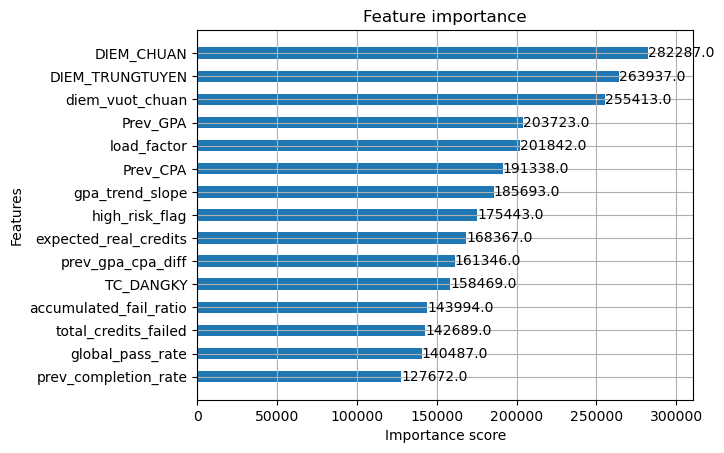

In [66]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 1. CẤU HÌNH XGBOOST CHO DATA CÓ CATEGORY ---
# Lưu ý: enable_categorical=True giúp XGBoost tự xử lý PTXT, TOHOP_XT
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=10000,
    learning_rate=0.001,
    
    # --- ÉP MODEL KHÔNG ĐƯỢC LƯỜI ---
    max_depth=10,                  # Giảm độ sâu để tránh học vẹt
    colsample_bytree=0.5,         # GIẢM MẠNH: Chỉ cho model nhìn 50% feature mỗi lần
                                  # Điều này buộc nó phải dùng các feature khác ngoài TC_DANGKY
    
    # --- TRỪNG PHẠT NHIỄU ---
    min_child_weight=7,           # Tăng lên: Buộc model bỏ qua các trường hợp cá biệt
    subsample=0.7,
    
    # Regularization
    reg_alpha=0.5,                # L1 reg: Loại bỏ feature rác
    reg_lambda=2.0,               # L2 reg: Giảm variance
    
    enable_categorical=True,
    random_state=42,
    n_jobs=-1
)

# --- 2. HUẤN LUYỆN MÔ HÌNH ---
print("Đang training model...")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=100
)

# --- 3. DỰ BÁO VÀ HẬU XỬ LÝ (POST-PROCESSING) ---
# Đây là bước quan trọng nhất để giảm RMSE
def post_process_prediction(model, X_df):
    # 1. Dự báo raw
    preds = model.predict(X_df)
    
    # 2. Làm tròn (Rounding): Tín chỉ phải là số nguyên
    # preds = np.round(preds)
    
    # 3. Chặn dưới (Clipping Lower): Không được âm
    preds = np.maximum(0, preds)
    
    # 4. CHẶN TRÊN (CLIPPING UPPER) - QUAN TRỌNG NHẤT
    # Sinh viên không thể hoàn thành nhiều hơn số đăng ký
    # Nếu model đoán 25 mà đăng ký có 20 -> Gán về 20
    if 'TC_DANGKY' in X_df.columns:
        preds = np.minimum(preds, X_df['TC_DANGKY'])
        
    return preds

# --- 4. ĐÁNH GIÁ KẾT QUẢ ---
y_pred_valid = post_process_prediction(model, X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
mae = mean_absolute_error(y_valid, y_pred_valid)
r2 = model.score(X_valid, y_valid)

print("\n" + "="*30)
print(f"KẾT QUẢ TRÊN TẬP VALIDATION:")
print(f"RMSE : {rmse:.4f} (Càng thấp càng tốt)")
print(f"MAE  : {mae:.4f}")
print(f"R2   : {r2:.4f}")
print("="*30)

# Xem feature nào quan trọng nhất
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=15, height=0.5)
plt.show()

Đang tạo target 'Số tín chỉ rớt'...
Đang cấu hình XGBoost Tweedie...
Bắt đầu training...
[0]	validation_0-tweedie-nloglik@1.3:12.04970	validation_1-tweedie-nloglik@1.3:12.90372
[100]	validation_0-tweedie-nloglik@1.3:11.31759	validation_1-tweedie-nloglik@1.3:12.06350
[200]	validation_0-tweedie-nloglik@1.3:11.14236	validation_1-tweedie-nloglik@1.3:11.89769
[300]	validation_0-tweedie-nloglik@1.3:11.07966	validation_1-tweedie-nloglik@1.3:11.86225
[400]	validation_0-tweedie-nloglik@1.3:11.04438	validation_1-tweedie-nloglik@1.3:11.85543
[500]	validation_0-tweedie-nloglik@1.3:11.02193	validation_1-tweedie-nloglik@1.3:11.85755
[600]	validation_0-tweedie-nloglik@1.3:11.00489	validation_1-tweedie-nloglik@1.3:11.86229
[700]	validation_0-tweedie-nloglik@1.3:10.99133	validation_1-tweedie-nloglik@1.3:11.86634
[800]	validation_0-tweedie-nloglik@1.3:10.98027	validation_1-tweedie-nloglik@1.3:11.87038
[900]	validation_0-tweedie-nloglik@1.3:10.97061	validation_1-tweedie-nloglik@1.3:11.87562
[1000]	valida

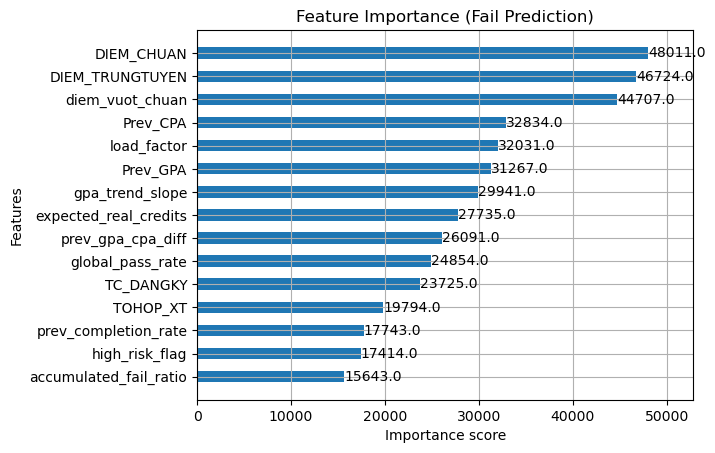

In [77]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ==========================================================
# 1. CHUẨN BỊ TARGET (CHIẾN THUẬT REVERSE)
# ==========================================================
# Thay vì đoán sinh viên ĐẬU bao nhiêu (phân phối chuẩn lệch),
# ta đoán sinh viên RỚT bao nhiêu (phân phối Tweedie - nhiều số 0).
print("Đang tạo target 'Số tín chỉ rớt'...")

# Tính số tín chỉ rớt = Đăng ký - Hoàn thành thực tế
y_train_fail = X_train['TC_DANGKY'] - y_train
y_valid_fail = X_valid['TC_DANGKY'] - y_valid

# Đảm bảo không âm (do nhiễu dữ liệu nếu có)
y_train_fail = np.maximum(0, y_train_fail)
y_valid_fail = np.maximum(0, y_valid_fail)

# ==========================================================
# 2. CẤU HÌNH XGBOOST (TWEEDIE VERSION)
# ==========================================================
print("Đang cấu hình XGBoost Tweedie...")

model = xgb.XGBRegressor(
    # --- QUAN TRỌNG NHẤT ---
    objective='reg:tweedie',      # Hàm loss tối ưu cho dữ liệu có nhiều số 0
    tweedie_variance_power=1.3,   # 1.3 phù hợp cho bài toán rớt tín chỉ
    
    # --- Cấu hình của bạn (Đã tinh chỉnh nhẹ) ---
    n_estimators=10000,           # Số lượng cây lớn
    learning_rate=0.01,           # Tăng nhẹ LR lên 0.01 để hội tụ nhanh hơn (0.001 quá chậm)
    
    max_depth=6,                  # Giảm từ 10 xuống 6: Tweedie cần cây nông hơn để tránh overfit
    min_child_weight=7,           # Giữ nguyên: Trừng phạt nhiễu tốt
    
    colsample_bytree=0.6,         # Giảm xuống 0.6 để model sáng tạo hơn
    subsample=0.7,
    
    # Regularization
    reg_alpha=0.5,
    reg_lambda=2.0,
    
    enable_categorical=True,      # Tự động xử lý PTXT, TOHOP_XT
    n_jobs=-1,
    random_state=42
)

# ==========================================================
# 3. HUẤN LUYỆN (CÓ EARLY STOPPING)
# ==========================================================
print("Bắt đầu training...")
model.fit(
    X_train, y_train_fail,
    # Eval set cũng phải dùng target rớt để so sánh
    eval_set=[(X_train, y_train_fail), (X_valid, y_valid_fail)],
    # eval_metric='rmse',
    verbose=100,
    # early_stopping_rounds=100     # <--- BẮT BUỘC PHẢI CÓ
)

# ==========================================================
# 4. DỰ BÁO & HẬU XỬ LÝ (REVERSE LOGIC)
# ==========================================================
def predict_and_convert(model, X_df):
    # 1. Model dự báo số tín chỉ RỚT
    pred_fail = model.predict(X_df)
    
    # 2. Chuyển đổi ngược: Đậu = Đăng ký - Rớt
    # Lưu ý: X_df phải có cột TC_DANGKY
    pred_pass = X_df['TC_DANGKY'] - pred_fail
    
    # 3. Hậu xử lý cơ bản
    pred_pass = np.maximum(0, pred_pass)
    pred_pass = np.minimum(pred_pass, X_df['TC_DANGKY'])
    
    return pred_pass

# ==========================================================
# 5. ĐÁNH GIÁ KẾT QUẢ
# ==========================================================
print("\nĐang đánh giá kết quả...")

# Dự báo trên tập Valid
y_pred_valid = predict_and_convert(model, X_valid)

# Tính RMSE trên số tín chỉ HOÀN THÀNH (Target gốc của đề bài)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
mae = mean_absolute_error(y_valid, y_pred_valid)

print("\n" + "="*40)
print(f"KẾT QUẢ XGBOOST (REVERSE TWEEDIE):")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print("="*40)

# Xem feature importance
xgb.plot_importance(model, max_num_features=15, height=0.5, title='Feature Importance (Fail Prediction)')
plt.show()

In [84]:
import pandas as pd
import numpy as np

# ==========================================================
# 1. LOAD & CHUẨN BỊ TẬP TEST
# ==========================================================
print("Đang load dữ liệu Test...")
df_test = pd.read_csv(TEST_PATH)
df_admission = pd.read_csv(ADMISSION_PATH)

# Merge thông tin tuyển sinh
df_test = df_test.merge(df_admission, on='MA_SO_SV', how='left')

# Bổ sung cột giả
df_test['HOC_KY'] = 'HK1 2024-2025' 
df_test['GPA'] = np.nan
df_test['CPA'] = np.nan
df_test['TC_HOANTHANH'] = np.nan 

# ==========================================================
# 2. TẠO FEATURE (GỘP LỊCH SỬ + TEST)
# ==========================================================
print("Đang tạo Features...")

# Lấy lại raw data từ train/valid gốc
raw_history = pd.concat([train, valid], axis=0, ignore_index=True)

# Gộp Test vào đuôi
full_data = pd.concat([raw_history, df_test], axis=0, ignore_index=True)

# Gọi FeatureEngineer
engineer = FeatureEngineer()
full_features = engineer.create_features(full_data)

# Tách lại tập Test (Học kỳ 20241)
test_features = full_features[full_features['semester_order'] == 20241].copy()

# Lấy đúng các cột dùng để train model
X_test = test_features[feature_cols]

print(f"Số lượng sinh viên cần dự báo: {len(X_test)}")

# ==========================================================
# 3. DỰ BÁO (DÙNG MODEL XGBOOST TWEEDIE)
# ==========================================================
print("Đang chạy dự báo...")

# Bước 1: Model dự báo SỐ TÍN CHỈ RỚT
pred_test_fail = model.predict(X_test)

# Bước 2: Chuyển đổi ngược (Đậu = Đăng ký - Rớt)
pred_test_hoanthanh = test_features['TC_DANGKY'] - pred_test_fail

# ==========================================================
# 4. HẬU XỬ LÝ (POST-PROCESSING)
# ==========================================================
# Ràng buộc 1: Không âm, không vượt quá đăng ký
pred_test_hoanthanh = np.maximum(0, pred_test_hoanthanh)
pred_test_hoanthanh = np.minimum(pred_test_hoanthanh, test_features['TC_DANGKY'])

# Ràng buộc 2: Tinh chỉnh cho Tân sinh viên
mask_freshman = test_features['semester_number'] == 1
mask_good_freshman = mask_freshman & (pred_test_fail < 1.5)
pred_test_hoanthanh[mask_good_freshman] = test_features.loc[mask_good_freshman, 'TC_DANGKY']

# Bước 3: Giữ nguyên Float (Không làm tròn int)
final_preds = pred_test_hoanthanh

# ==========================================================
# 5. XUẤT FILE
# ==========================================================
submission = pd.DataFrame({
    'MA_SO_SV': test_features['MA_SO_SV'],
    'PRED_TC_HOANTHANH': final_preds
})

# Đã bỏ dòng sort theo yêu cầu của bạn
# submission = submission.sort_values('MA_SO_SV')

# Lưu file
filename = 'submission_xgboost_tweedie.csv'
submission.to_csv(filename, index=False)

print(f"\nĐã xuất file: {filename}")
print(submission.head())

# Kiểm tra nhanh
print("\nThống kê kết quả dự báo (Float):")
print(submission['PRED_TC_HOANTHANH'].describe())

Đang load dữ liệu Test...
Đang tạo Features...
Số lượng sinh viên cần dự báo: 16502
Đang chạy dự báo...

Đã xuất file: submission_xgboost_tweedie.csv
        MA_SO_SV  PRED_TC_HOANTHANH
2   00003e092652          17.149526
3   00027b0dec4c          19.000000
10  000e15519006          18.004168
13  000ea6e12003          17.263252
16  00109b845a3d           3.381916

Thống kê kết quả dự báo (Float):
count    16502.000000
mean        15.148344
std          5.833710
min          0.000000
25%         12.148508
50%         15.877578
75%         18.987451
max         57.272162
Name: PRED_TC_HOANTHANH, dtype: float64
